## EVALUATION

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score, accuracy_score

import joblib

import shap
import streamlit as st
from streamlit_shap import st_shap


In [2]:
def load_data():
    X_train = pd.read_csv('../input/Train.csv', sep=',').set_index('id')
    X_val = pd.read_csv('../input/Val.csv', sep=',').set_index('id')
    X_test = pd.read_csv('../input/Test.csv', sep=',').set_index('id')
    df00_not_norm = pd.read_csv('../input/df_not_norm.csv', index_col='id')
    return X_train, X_val, X_test, df00_not_norm


## salvar lista do nome dos modelos no notebook 03
def load_models():
    models_names_short = ['gaussian', 'logreg', 'dectree', 'rndforest', 'gbc', 'xgb_classifier']

    # Nomes dos arquivos dos modelos
    model_files = {
        'modelo0': "../artifacts/" + models_names_short[0] + "_model.joblib",
        'modelo1': "../artifacts/" + models_names_short[1] + "_model.joblib",
        'modelo2': "../artifacts/" + models_names_short[2] + "_model.joblib",
        'modelo3': "../artifacts/" + models_names_short[3] + "_model.joblib",
        'modelo4': "../artifacts/" + models_names_short[4] + "_model.joblib",
        'modelo5': "../artifacts/" + models_names_short[5] + "_model.joblib",
    }

    # Carregar os modelos
    models = {name: joblib.load(path) for name, path in model_files.items()}
    return models


def plot_roc_curves(df00, models, model_names, info, figsize=(12,8)):
    """
    Plots ROC curves for a list of models.

    Parameters:
    X (numpy.ndarray or pandas.DataFrame): input features for the models
    y (numpy.ndarray or pandas.DataFrame): target variable
    models (list): list of models to compare
    model_names (list): list of model names to display on the plot
    info (string): info about validation or test dataset. 'validation' or 'test'
    figsize (tuple): size of the figure to display the plot

    Returns:
    None
    """
    X = df00.drop(columns=['target'])
    y = df00.target
    fig, ax = plt.subplots(figsize=figsize)
    models_ = []
    roc_auc_ = []
    # Loop over models and plot ROC curve
    for i, model in enumerate(models):
        y_pred = list(model.predict_proba(X)[:, 1])
        fpr, tpr, threshold = metrics.roc_curve(y, y_pred)
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=(model_names[i] + ' AUC = %0.4f' % roc_auc), linewidth=2.0)
        models_.append(model_names[i])
        roc_auc_.append(roc_auc) 
    

    ax.grid(False)
    ax.tick_params(length=6, width=2, labelsize=15, grid_color='r', grid_alpha=0.5)
    leg = plt.legend(loc='lower right', prop={'size': 15})
    leg.get_frame().set_edgecolor('b')
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=20)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
#     plt.show()
    return (
    pd.DataFrame(data={
        'Model':models_,
        'AUC_'+info:roc_auc_,
    })
    )

# Define a function to find the best threshold for a given model
def find_best_threshold(df00, model, num_steps):
    X_val = df00.drop(columns=['target'])
    y_val = df00.target
    highest_f1 = 0
    best_threshold = 0
    best_acc = 0
    best_rec = 0
    best_pre = 0
    # Iterate over a range of thresholds
    for threshold in np.linspace(0, 1, num_steps):
        # Predict the target variable using the given threshold
        y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
        # Calculate various evaluation metrics
        f1 = f1_score(y_val, y_predict)
        acc = accuracy_score(y_val, y_predict)
        rec = recall_score(y_val, y_predict)
        pre = precision_score(y_val, y_predict)
        # Update the best threshold and metrics if F1 score improves
        if f1 > highest_f1:
            best_threshold, highest_f1, best_acc, best_rec, best_pre = \
                threshold, f1, acc, rec, pre
    # Return the best threshold and evaluation metrics
    return best_threshold, highest_f1, best_acc, best_rec, best_pre

def build_decision_table(models, model_names, X_val, auc_roc_table):
    # Create an empty list to store the results
    chart = list()

    # Iterate over the models and find the best threshold for each one
    for item, name in zip(models, model_names):
        best_thresh, high_f1, high_acc, high_rec, high_pre = find_best_threshold(X_val, item, 20)
        # Append the results to the chart list
        chart.append([name, best_thresh, high_f1, high_acc, high_rec, high_pre])

    # Create a pandas dataframe from the chart list and display it
    chart = pd.DataFrame(chart, columns=['Model', 'Best Threshold', 'F1 Score', 'Accuracy', 'Recall', 'Precision'])
    # chart.to_csv('model_evaluation_scores.csv')
    decision_table = pd.merge(auc_roc_table,chart, how='left', on='Model')
    return decision_table

def choice_best_model(decision_table, dict_model_names_to_object):
    best_model_name = decision_table.sort_values(by='AUC_test', ascending=False)['Model'][0]
    print(best_model_name)
    best_model = dict_model_names_to_object[best_model_name]
    return best_model

def make_confusion_matrix(df00, model, decision_table,info='num', threshold=0.5):
    """
    Generates a confusion matrix for a given model on the test dataset, given a threshold.

    Args:
    - model: a trained machine learning model
    - info: plot num or perc in confusion matrix
    - threshold: threshold for binary classification

    Returns: None
    """
    
    model_name = str(model).split('(')[0]
    threshold = decision_table[decision_table['Model'] == model_name]['Best Threshold'].values[0]
    X_test = df00.drop(columns=['target'])
    y_test = df00.target
    # Predict class 1 if probability of being in class 1 is greater than threshold
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)

    # Generate confusion matrix
    _confusion = confusion_matrix(y_test, y_predict)

    # Plot heatmap of confusion matrix
    plt.figure(dpi=100)
    sns.set(font_scale=1)
    if info=='num':
        sns.heatmap(_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
                    xticklabels=['Not Default', 'Default'],
                    yticklabels=['Not Default', 'Default'])
    else:
        sns.heatmap(_confusion/np.sum(_confusion), cmap=plt.cm.Blues, annot=True, 
                    square=True, 
                    fmt='.3%',
                    xticklabels=['Not Default', 'Default'],
                    yticklabels=['Not Default', 'Default'])

    # Calculate TP, FP, FN, TN
    TP = _confusion[0][0]
    FP = _confusion[0][1]
    FN = _confusion[1][0]
    TN = _confusion[1][1]
    
    tot = TP+FP+FN+TN
    print(round(100*FN/(tot),2),round(100*TN/(tot),2), round(100*(FN/(tot) + TN/(tot)),2))
    
    # Add title, labels and rotate y-tick labels
    plt.yticks(rotation=0)
    plt.title('Predicted vs. Actual', 
    fontsize=20, pad=10)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

def score_build_dfs(X_train, X_val, X_test, best_model):
    # Train
    Train = X_train.copy()
    Train['y_pred'] = best_model.predict(X_train.drop(columns='target'))
    Train['y_score'] = best_model.predict_proba(X_train.drop(columns='target'))[:,1]

    # Validation
    Val = X_val.copy()
    Val['y_pred'] = best_model.predict(X_val.drop(columns='target'))
    Val['y_score'] = best_model.predict_proba(X_val.drop(columns='target'))[:,1]

    # Test
    Test = X_test.copy()
    Test['y_pred'] = best_model.predict(X_test.drop(columns='target'))
    Test['y_score'] = best_model.predict_proba(X_test.drop(columns='target'))[:,1]

    return Train, Val, Test

def save_final_dataset(Train, Val, Test):
    Train.to_csv('../input/Train_after_modeling.csv', sep=',', encoding='utf-8',index=True)
    Val.to_csv('../input/Val_after_modeling.csv', sep=',', encoding='utf-8',index=True)
    Test.to_csv('../input/Test_after_modeling.csv', sep=',', encoding='utf-8',index=True)

def obtain_shap_values(best_model, X_train):
    # compute SHAP values
    explainer = shap.Explainer(best_model)
    shap_values = explainer(X_train)
    return explainer, shap_values

def save_shap_objects(explainer, shap_values):
    joblib.dump(explainer,"../artifacts/explainer.joblib")
    joblib.dump(shap_values,"../artifacts/shap_values.joblib")

def load_shap_objects():
    explainer = joblib.load("../artifacts/explainer.joblib")
    shap_values = joblib.load("../artifacts/shap_values.joblib")
    return explainer, shap_values

def plot_feature_importances(best_model, X_train):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)
    features = X_train.columns.tolist()
    plt.title('Feature Importances')
    j = 11 # top j importance
    plt.barh(range(j), importances[indices][len(indices)-j:], color='g', align='center')
    #plt.barh(range(len(indices)), importances[indices], color='g', align='center')
    plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
    plt.xlabel('Relative Importance')
    plt.show()

def plot_summary_shap(shap_values, X_train):
    # st_shap(shap.plots.beeswarm(shap_values), height=300)
    shap.summary_plot(shap_values, X_train.values, feature_names = X_train.columns)    

def FaixasDecil(dataframe,scorename,targetname):
    
    dataframe['good'] = 1 - dataframe[targetname]
    dataframe['bucket'] = pd.qcut(dataframe[scorename], 10,duplicates='drop')
    grouped = dataframe.groupby('bucket', as_index = False)
    agg1 = grouped.min()[scorename].values
    agg1 = pd.DataFrame(data=agg1, columns = ['min_scr'])
    
    agg1['max_scr'] = grouped.max()[scorename]
    
    agg1['bads'] = grouped.sum()[targetname]
    agg1['goods'] = grouped.sum().good
    agg1['total'] = agg1.bads + agg1.goods
    
    # agg2 = (agg1.sort_index(by = 'min_scr')).reset_index(drop = True)
    agg2 = (agg1.sort_values(by = 'min_scr')).reset_index(drop = True)
    agg2['odds'] = (agg2.goods / agg2.bads).apply('{0:.2f}'.format)
    agg2['bad_rate'] = (agg2.bads / agg2.total).apply('{0:.2%}'.format)
    agg2['ks'] = np.round((-(agg2.bads / dataframe[targetname].sum()).cumsum() + (agg2.goods / dataframe.good.sum()).cumsum()), 4) * 100
    # agg2['ks'] = np.round((-(agg2.bads).cumsum() + (agg2.goods).cumsum()), 4) * 100
    flag = lambda x: '<== KS ==' if x == agg2.ks.max() else ''
    agg2['max_ks'] = agg2.ks.apply(flag)
    ks_valor = round(agg2.sort_values(by='ks', ascending=False)['ks'].iloc[0],2)
    
    return agg2, ks_valor

def FaixasCentil(dataframe,scorename,targetname,num=10000):
    data_bad = dataframe[targetname].copy()
    dataframe['good'] = 1 - dataframe[targetname]
    data_good = dataframe['good'].copy()
    dataframe['bucket'] = pd.qcut(dataframe[scorename], 100,duplicates='drop')
    grouped = dataframe.groupby('bucket', as_index = False)
    agg1 = grouped.min()[scorename].values
    agg1 = pd.DataFrame(data=agg1, columns = ['min_scr'])
    
    agg1['max_scr'] = grouped.max()[scorename]
    
    agg1['bads'] = grouped.sum()[targetname]
    agg1['goods'] = grouped.sum().good
    agg1['total'] = agg1.bads + agg1.goods
    
    # agg2 = (agg1.sort_index(by = 'min_scr')).reset_index(drop = True)
    agg2 = (agg1.sort_values(by = 'min_scr')).reset_index(drop = True)
    agg2['odds'] = (agg2.goods / agg2.bads).apply('{0:.2f}'.format)
    agg2['perc_bad_rate'] = (agg2.bads / agg2.total).apply('{0:.2%}'.format)
    agg2['bad_rate'] = (agg2.bads / agg2.total)*100

    agg2['ks'] = np.round((-(agg2.bads / data_bad.sum()).cumsum() + (agg2.goods / data_good.sum()).cumsum()), 4) * 100
    # agg2['ks'] = np.round((-(agg2.bads).cumsum() + (agg2.goods).cumsum()), 4) * 100
    flag = lambda x: '<== KS ==' if x == agg2.ks.max() else ''
    agg2['max_ks'] = agg2.ks.apply(flag)
    ks_valor = round(agg2.sort_values(by='ks', ascending=False)['ks'].iloc[0],2)
    agg2['min_scr'] = agg2['min_scr'].mul(num)
    agg2['max_scr'] = agg2['max_scr'].mul(num)
    
    return agg2, ks_valor    


def build_policy_propensity(agg2,bins, labels, num):
     agg2['Propensity_Class'] = pd.cut(agg2.max_scr, bins=bins, 
                         labels=labels,
          include_lowest=True,
          right=True)

     grouped = agg2.groupby('Propensity_Class', as_index = False)
     agg3 = pd.DataFrame()
     agg3['min_scr'] = grouped.min()['min_scr']
     agg3['max_scr'] = grouped.max()['max_scr']

     agg3['bads'] = grouped.sum()['bads']
     agg3['goods'] = grouped.sum()['goods']
     agg3['total'] = agg3.bads + agg3.goods


     agg3['perc_bad_rate'] = (agg3.bads / agg3.total).apply('{0:.1%}'.format)
     agg3['bad_rate'] = (agg3.bads / agg3.total)*100

     agg3['perc_bads'] = (agg3.bads / agg2.bads.sum()).apply('{0:.1%}'.format)
     agg3['pbads'] = (agg3.bads / agg2.bads.sum())*100

     agg3['perc_goods'] = (agg3.goods / agg2.goods.sum()).apply('{0:.1%}'.format)
     agg3['pgoods'] = (agg3.goods / agg2.goods.sum())*100

     agg3['perc_propensity'] = (agg3.bads / agg2.total.sum()).apply('{0:.2%}'.format)
     agg3['ppropensity'] = (agg3.bads / agg2.total.sum())*100

     agg3['perc_population'] = (agg3.total / agg2.total.sum()).apply('{0:.0%}'.format)
     agg3['ppopulation'] = (agg3.total / agg2.total.sum())*100

     agg3['Propensity Bands'] = labels
     # agg3['min_scr'].iloc[0] = 0
     agg3_shift = agg3['max_scr'].shift()
     agg3_shift.iloc[0]=0
     agg3['min_scr'] = agg3_shift
     agg3['max_scr'].iloc[-1] = 1
     agg3['Score Ranges'] = (agg3['min_scr'].mul(num)).round(4).astype(str) + ' a ' + agg3['max_scr'].mul(num).round(4).astype(str)


     _prop_pol = agg3[['Propensity Bands','Score Ranges','perc_population','perc_bads','perc_goods','perc_propensity']]
     prop_pol = _prop_pol.rename(columns={
                              'Propensity Bands':'Risk Bands',
                         #      'Score Ranges':'Faixas de Score', 
                              'perc_population':'% of Population', 
                              'perc_bads':'% Bads', 
                              'perc_goods':'% Goods', 
                              'perc_propensity':'% Risk'})

     
     return prop_pol, agg3

def save_policy(prop_pol):
     prop_pol.to_csv('../artifacts/prop_pol.csv')                          

def define_recommendation_threshold_decision(agg3, prop_pol, Test):
    _bins = agg3.min_scr.tolist()
    _bins.append(1)
    _bins

    _labels = prop_pol['Risk Bands'].tolist()
    _labels
    Test.columns
    # Create Propensity Bands on Test dataset
    Test['Risk Bands'] = pd.cut(Test['y_score'], bins=_bins, labels=_labels, right=False)

    # Define recomendation
    Test['Risk_Recomendation'] = Test['Risk Bands'].apply(lambda x: 1 if x in ["Medium High", "High"] else 0)

    threshold_medium_risk_decision = Test[Test['Risk Bands']=="Medium High"]['y_score'].min()
    
    threshold_high_risk_decision = Test[Test['Risk Bands']=="High"]['y_score'].min()
    

    return Test, threshold_medium_risk_decision, threshold_high_risk_decision

def save_threshold_risk(threshold_medium_risk_decision, threshold_high_risk_decision):
    joblib.dump(threshold_medium_risk_decision, "../artifacts/threshold_medium_risk_decision.joblib")

    joblib.dump(threshold_high_risk_decision, "../artifacts/threshold_high_risk_decision.joblib")
    


def plot_hist_propension_score(Test):
    # group data
    grouped_data = Test.groupby('target')['y_score']

    # Histogram 1
    # plt.hist([grouped_data.get_group(key) for key in grouped_data.groups.keys()], bins=5, alpha=0.5, label=grouped_data.groups.keys())
    plt.hist([grouped_data.get_group(key) for key in grouped_data.groups.keys()], bins=10, alpha=1, label=[0,1])

    # title
    plt.title('Histogram of Propensity Score x Charge Off')

    # axis
    plt.xlabel('Risk Score')
    plt.ylabel('Frequency')
    plt.ylim(0,22000)
    # legend
    plt.legend(title='Charge Off')

    # show
    plt.show()

def plot_hist_propension_score2(Test):
    ## Histogram 2
    Test.groupby('target')['y_score'].hist(bins=5,alpha=0.6) 
    plt.title('Histogram of Propensity Score X Default')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.ylim(0,30000)
    plt.legend(labels=[0,1],title='Charge Off')
    plt.show()


## Load Data

In [3]:
X_train, X_val, X_test, df00_not_norm = load_data()

In [4]:
X_test.head()

,loan_amnt,term,emp_length,annual_inc,addr_state,dti,mths_since_recent_inq,bc_open_to_buy,num_op_rev_tl,home_ownership_MORTGAGE,home_ownership_OTHERS,home_ownership_OWN,home_ownership_RENT,target
id,,,,,,,,,,,,,,
93952372,0.065237,-0.564595,1.127018,-0.087128,0.875601,0.251863,7.854928e-01,-0.405707,1.287916,0,0,1,0,0
15741465,1.211835,-0.564595,1.127018,-0.224658,-0.504480,0.778456,5.281836e-02,-0.606024,2.188266,1,0,0,0,0
55198988,-1.482670,-0.564595,-1.386813,-0.637249,0.507580,-0.985720,-1.626864e-16,-0.644090,-0.962959,0,0,0,1,0
16642377,-0.049423,1.771181,1.127018,0.256697,-0.504480,-0.178986,5.281836e-02,-0.503203,-0.512784,1,0,0,0,0
1562329,-0.671452,-0.564595,0.568389,-0.704790,0.691590,-0.170121,-1.626864e-16,-0.636304,-0.287696,0,0,0,1,0


In [5]:
X_test.columns


Index(['loan_amnt', 'term', 'emp_length', 'annual_inc', 'addr_state', 'dti',
       'mths_since_recent_inq', 'bc_open_to_buy', 'num_op_rev_tl',
       'home_ownership_MORTGAGE', 'home_ownership_OTHERS',
       'home_ownership_OWN', 'home_ownership_RENT', 'target'],
      dtype='object')

## Load models

In [6]:
models = load_models()
# Agora você pode acessar cada modelo pelo seu nome, por exemplo:
gaussian = models['modelo0']
logreg = models['modelo1']
dectree = models['modelo2']
rndforest = models['modelo3']
gbc = models['modelo4']
xgb_classifier = models['modelo5']

# Define the list of models to compare
models = [gaussian, logreg, dectree, rndforest, gbc, xgb_classifier]

model_names = []
for model in models:
    model_names.append(str(model).split('(')[0])

dict_model_names_to_speak = {
'GaussianNB': 'Gaussian Naive Bayes',
'LogisticRegression': 'Logistic Regression', 
'DecisionTreeClassifier': 'Decision Tree', 
'RandomForestClassifier': 'RandomForest', 
'GradientBoostingClassifier': 'Gradient Boosting', 
'XGBClassifier': 'XGBoost'
}

dict_model_names_to_tec = {
'Gaussian Naive Bayes': 'GaussianNB', 
'Logistic Regression': 'LogisticRegression', 
'Decision Tree': 'DecisionTreeClassifier', 
'RandomForest': 'RandomForestClassifier', 
'Gradient Boosting': 'GradientBoostingClassifier', 
'XGBoost': 'XGBClassifier', 
}

dict_model_names_to_object = dict(zip(model_names,models))
dict_model_names_to_object

{'GaussianNB': GaussianNB(),
 'LogisticRegression': LogisticRegression(C=1, multi_class='ovr', n_jobs=1, solver='liblinear'),
 'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=4, min_samples_leaf=2),
 'RandomForestClassifier': RandomForestClassifier(max_depth=3, n_estimators=10),
 'GradientBoostingClassifier': GradientBoostingClassifier(validation_fraction=0.2),
 'XGBClassifier': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=100,
               n_jobs=-1, nthr

In [7]:
models

[GaussianNB(),
 LogisticRegression(C=1, multi_class='ovr', n_jobs=1, solver='liblinear'),
 DecisionTreeClassifier(max_depth=4, min_samples_leaf=2),
 RandomForestClassifier(max_depth=3, n_estimators=10),
 GradientBoostingClassifier(validation_fraction=0.2),
 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=100,
               n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
               random_state=0, reg_alpha=0, ...)]

In [8]:
model_names

['GaussianNB',
 'LogisticRegression',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'GradientBoostingClassifier',
 'XGBClassifier']

### Plot AUC-ROC curves

,Model,AUC_test
0,GaussianNB,0.659490
1,LogisticRegression,0.671052
2,DecisionTreeClassifier,0.651497
3,RandomForestClassifier,0.663051
4,GradientBoostingClassifier,0.685604
5,XGBClassifier,0.685140


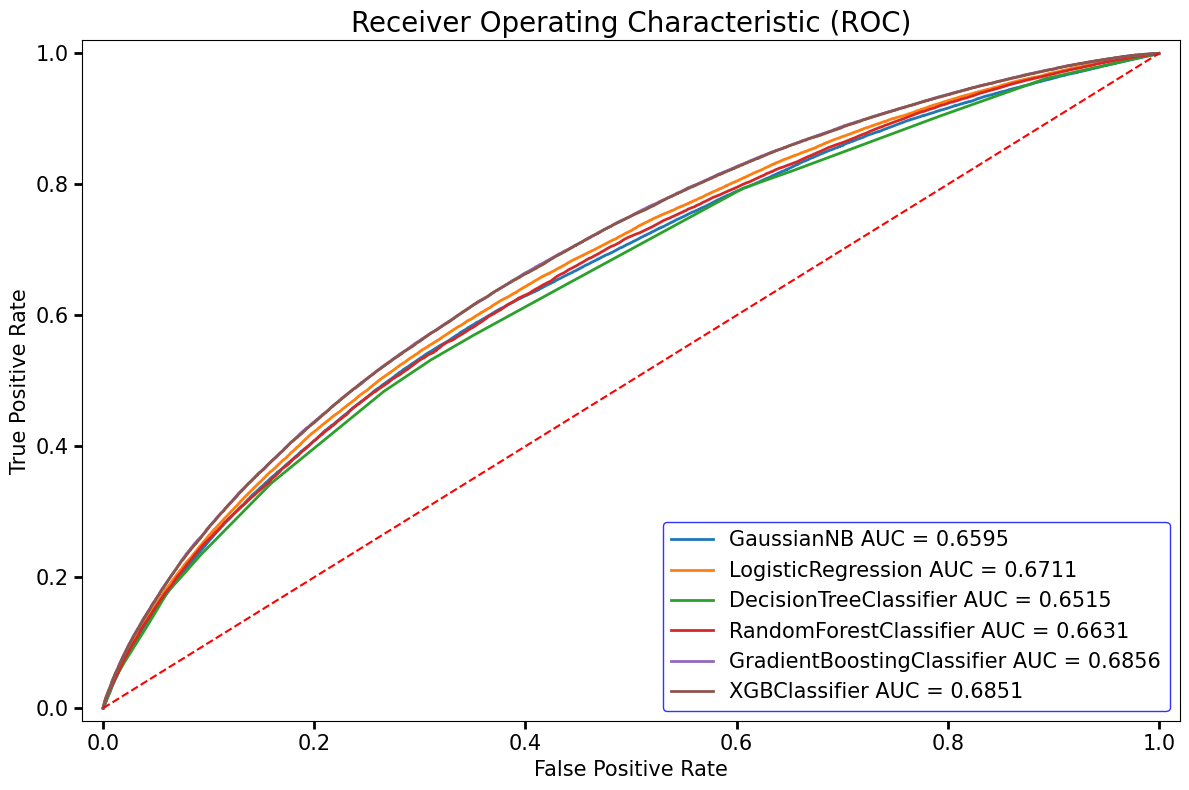

In [9]:
# Plot ROC curves for out-of-sample data
test_roc_auc = plot_roc_curves(X_test, models, model_names, info='test')
test_roc_auc

## Best ROC AUC Model

In [10]:
# auc_roc_table = pd.merge(val_roc_auc,test_roc_auc,how='left',on='Model').sort_values(by='AUC_test',ascending=False)
auc_roc_table = test_roc_auc.sort_values(by='AUC_test',ascending=False)

auc_roc_table

,Model,AUC_test
4,GradientBoostingClassifier,0.685604
5,XGBClassifier,0.685140
1,LogisticRegression,0.671052
3,RandomForestClassifier,0.663051
0,GaussianNB,0.659490
2,DecisionTreeClassifier,0.651497


### Optimal threshold

In [11]:
decision_table = build_decision_table(models, model_names, X_test, auc_roc_table)
decision_table

,Model,AUC_test,Best Threshold,F1 Score,Accuracy,Recall,Precision
0,GradientBoostingClassifier,0.685604,0.210526,0.406439,0.670712,0.564753,0.317451
1,XGBClassifier,0.685140,0.210526,0.406236,0.668054,0.568830,0.315930
2,LogisticRegression,0.671052,0.210526,0.396632,0.663936,0.553321,0.309100
3,RandomForestClassifier,0.663051,0.210526,0.384823,0.688756,0.487656,0.317807
4,GaussianNB,0.659490,0.210526,0.388840,0.601464,0.635091,0.280197
5,DecisionTreeClassifier,0.651497,0.210526,0.379478,0.684132,0.483821,0.312156


## Choice the best Model based in highest AUC

In [12]:
best_model = choice_best_model(decision_table, dict_model_names_to_object)
best_model

GradientBoostingClassifier


GradientBoostingClassifier(validation_fraction=0.2)

### Confusion Matrix

### Confusion Matrix for best Model

8.69 11.27 19.96


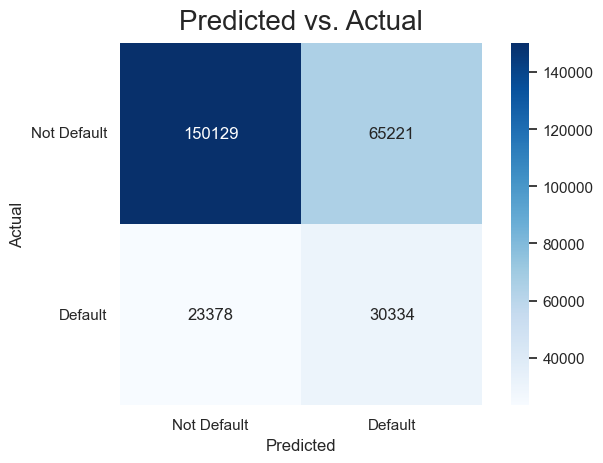

In [13]:
# Generate confusion matrix for best model on test dataset
make_confusion_matrix(X_test,best_model, decision_table)

8.69 11.27 19.96


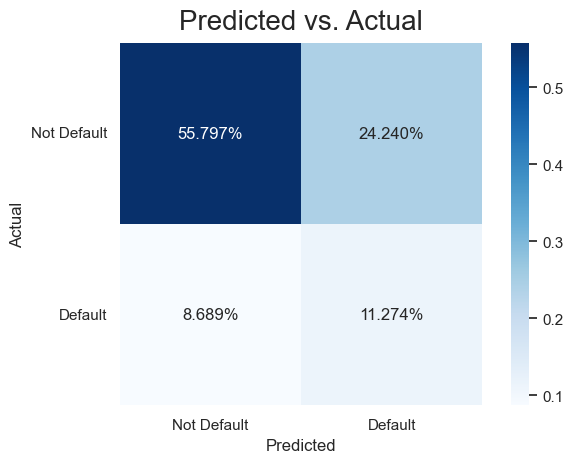

In [14]:
# Generate confusion matrix for best model on test dataset
make_confusion_matrix(X_test,best_model,decision_table, info='perc')

## Adding results to Train, Val and Test dataframe

In [15]:
X_train.head()

,loan_amnt,term,emp_length,annual_inc,addr_state,dti,mths_since_recent_inq,bc_open_to_buy,num_op_rev_tl,home_ownership_MORTGAGE,home_ownership_OTHERS,home_ownership_OWN,home_ownership_RENT,target
id,,,,,,,,,,,,,,
105253408,0.179897,-0.564595,2.890743e-01,0.119112,0.231563,0.410550,2.617179,-0.612346,-1.188047,1,0,0,0,1
16592425,0.546808,1.771181,-4.961623e-16,-0.183949,-0.964507,0.069240,-1.046193,0.647717,1.963179,0,0,1,0,0
58470345,-0.966701,-0.564595,2.890743e-01,-0.637249,0.967607,-1.046003,-0.679856,-0.678630,-1.188047,0,0,0,1,0
10092824,-0.508062,-0.564595,2.890743e-01,1.013113,-0.596485,-0.662140,0.785493,7.479771,5.789667,1,0,0,0,0
65965690,0.753196,-0.564595,1.127018e+00,0.930595,-2.068572,0.227040,-0.130350,0.558540,-0.287696,1,0,0,0,1


In [16]:
Train, Val, Test = score_build_dfs(X_train, X_val, X_test, best_model)


## Saving Train, Val and Test datraframe with results.

In [17]:
save_final_dataset(Train, Val, Test)

## Explain ML Model

#### Feature Importance

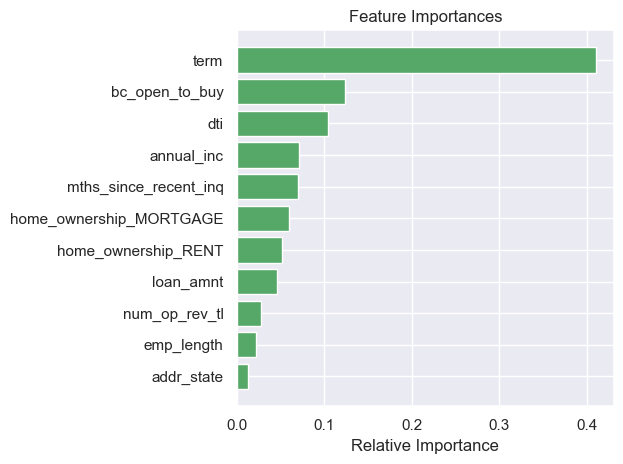

In [18]:
plot_feature_importances(best_model, X_train.drop(columns='target'))

### Shap Importance

In [19]:
explainer, shap_values = obtain_shap_values(best_model, X_train.drop(columns='target'))

# save_shap_objects(explainer, shap_values)

In [20]:
# explainer, shap_values = load_shap_objects()

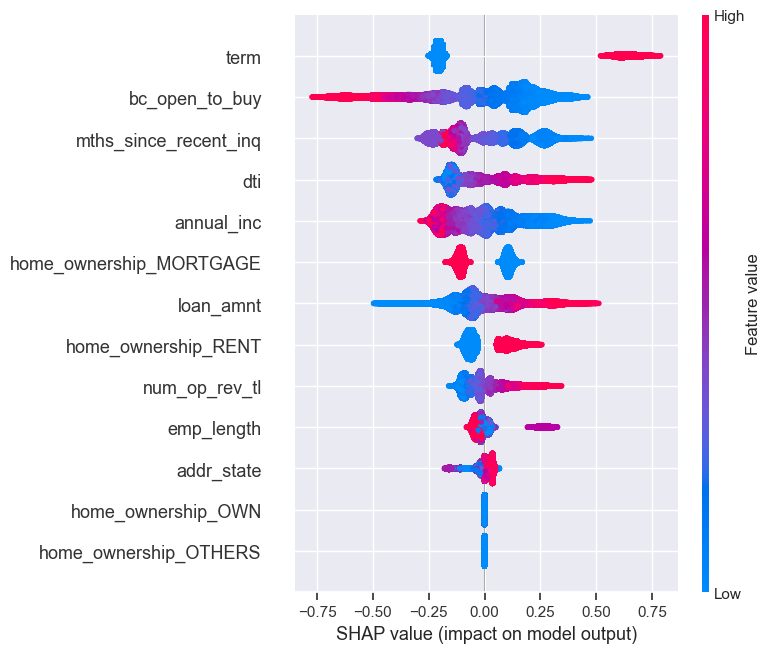

In [21]:
plot_summary_shap(shap_values, X_train.drop(columns='target'))

### Testando shap para um individuo apenas!!

In [22]:
Train.head(2).T

id,105253408,16592425
loan_amnt,0.179897,5.468080e-01
term,-0.564595,1.771181e+00
emp_length,0.289074,-4.961623e-16
annual_inc,0.119112,-1.839493e-01
addr_state,0.231563,-9.645070e-01
dti,0.410550,6.923963e-02
mths_since_recent_inq,2.617179,-1.046193e+00
bc_open_to_buy,-0.612346,6.477174e-01
num_op_rev_tl,-1.188047,1.963179e+00
home_ownership_MORTGAGE,1.000000,0.000000e+00


In [23]:
df00_not_norm = pd.read_csv('../input/df_not_norm.csv', index_col='id')

In [24]:
Train.loc[16592425]

loan_amnt                  5.468080e-01
term                       1.771181e+00
emp_length                -4.961623e-16
annual_inc                -1.839493e-01
addr_state                -9.645070e-01
dti                        6.923963e-02
mths_since_recent_inq     -1.046193e+00
bc_open_to_buy             6.477174e-01
num_op_rev_tl              1.963179e+00
home_ownership_MORTGAGE    0.000000e+00
home_ownership_OTHERS      0.000000e+00
home_ownership_OWN         1.000000e+00
home_ownership_RENT        0.000000e+00
target                     0.000000e+00
y_pred                     0.000000e+00
y_score                    4.110266e-01
Name: 16592425, dtype: float64

In [25]:
df00_not_norm.loc[16592425]

loan_amnt                  19200.000000
term                           2.000000
emp_length                     5.965058
annual_inc                 62960.000000
addr_state                    30.000000
dti                           19.060000
mths_since_recent_inq          1.000000
bc_open_to_buy             19930.000000
num_op_rev_tl                 17.000000
home_ownership_MORTGAGE        0.000000
home_ownership_OTHERS          0.000000
home_ownership_OWN             1.000000
home_ownership_RENT            0.000000
target                         0.000000
Name: 16592425, dtype: float64

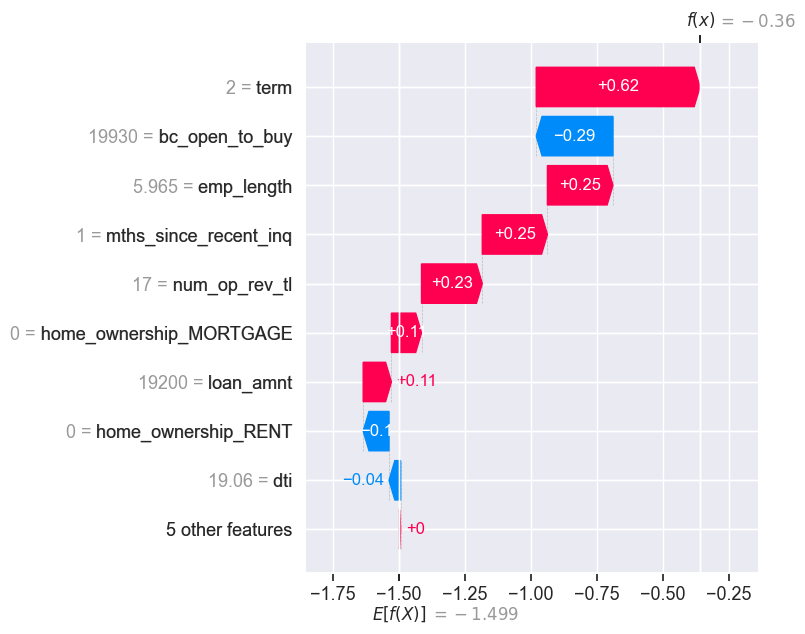

2024-03-05 18:38:39.763 
  command:

    streamlit run /Users/rafaelr/MyProjects/loan_bank_model_project_v1/env_loan_bank/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

In [26]:
# Calcular os valores SHAP para uma única instância
# instance_index = 0  # Índice da instância que você deseja explicar
id = 105253408
id = 16592425
# shap_values_instance = explainer(np.expand_dims(X_train.values[instance_index], axis=0))
shap_values_instance = explainer(np.expand_dims(X_train.loc[id].values, axis=0))

# Criar um objeto Explanation que inclui os nomes das features
explanation = shap.Explanation(
    values=shap_values_instance.values[0],  # Valores SHAP para a instância
    base_values=shap_values_instance.base_values[0],  # Valor base
    # data=X_train.iloc[instance_index],  # Dados da instância
    data=df00_not_norm.loc[id],
    feature_names=X_train.columns  # Nomes das features
)

# Gerar e exibir o gráfico de cascata com os nomes das features
st_shap(shap.plots.waterfall(explanation), height=300)

### Selecting features
- loan_amnt - The listed amount of the loan applied by the borrower.
- term - The number of payments on the loan, where values are in months and can be either 36 or 60.
- int_rate - The interest rate on the loan
- sub_grade - Assigned loan subgrade score based on borrower's credit history
- emp_length - Borrow's employment length in years.
- home_ownership - The homeownership status provided by the borrower (eg rent, own, mortgage, etc)
- annual_inc - The self-reported annual income provided by the borrower
- addr_state - The state provided by the borrower in the loan application
- dti - A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage, divided by the borrower’s monthly income.
- mths_since_recent_inq - Months since most recent inquiry
- revol_util - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
- bc_open_to_buy - Total open to buy on revolving bankcards
- bc_util - Ratio of total current balance to high credit/credit limit for all bankcard accounts
- num_op_rev_tl - Number of open revolving accounts
- loan_status - Current status of the loan (eg fully paid or charged off), this is the label we are going to predict with the model.

### Explain Features and yours values.
- loan with 60 months have higher probability to have Charge Off status in future.
- For lower values on bc_open_to_buy, mths_since_recent_inq and annual_inc have more probability of Charge Off status in future.
- For higher values on dti, loan_amount and num_op_rev_tl there are higher probability of Charge Off status in future.
- There are higher probability of Charge Off status for Borrowers dont have Mortage or have Rent status.  


## Policy Function

In [27]:
agg, ks_valor = FaixasDecil(Test,'y_score','target')

In [28]:
display(agg)
# print(agg.to_csv(lineterminator='\r\n'))

,min_scr,max_scr,bads,goods,total,odds,bad_rate,ks,max_ks
0,0.030607,0.094953,1589,25318,26907,15.93,5.91%,8.80,
1,0.094954,0.117246,2556,24350,26906,9.53,9.50%,15.35,
2,0.117248,0.136301,3137,23769,26906,7.58,11.66%,20.54,
3,0.136302,0.155072,3842,23064,26906,6.00,14.28%,24.10,
4,0.155072,0.175244,4569,22337,26906,4.89,16.98%,25.97,
5,0.175247,0.198511,5149,21757,26906,4.23,19.14%,26.48,<== KS ==
6,0.198511,0.227702,5890,21016,26906,3.57,21.89%,25.28,
7,0.227703,0.269714,6952,19954,26906,2.87,25.84%,21.60,
8,0.269715,0.342438,8384,18522,26906,2.21,31.16%,14.59,
9,0.342439,0.763511,11644,15263,26907,1.31,43.27%,0.00,


In [29]:
agg2, ks_valor = FaixasCentil(Test,'y_score','target',num=1)

In [30]:
pd.set_option('display.max_rows', 500)
display(agg2)

,min_scr,max_scr,bads,goods,total,odds,perc_bad_rate,bad_rate,ks,max_ks
0,0.030607,0.057290,63,2628,2691,41.71,2.34%,2.341137,1.10,
1,0.057305,0.065518,100,2592,2692,25.92,3.71%,3.714710,2.12,
2,0.065524,0.071248,134,2555,2689,19.07,4.98%,4.983265,3.06,
3,0.071249,0.075630,155,2536,2691,16.36,5.76%,5.759941,3.95,
4,0.075630,0.079700,162,2529,2691,15.61,6.02%,6.020067,4.82,
5,0.079700,0.083221,175,2515,2690,14.37,6.51%,6.505576,5.66,
6,0.083222,0.086478,170,2521,2691,14.83,6.32%,6.317354,6.52,
7,0.086482,0.089430,202,2488,2690,12.32,7.51%,7.509294,7.29,
8,0.089433,0.092256,217,2474,2691,11.40,8.06%,8.063917,8.04,
9,0.092258,0.094953,211,2480,2691,11.75,7.84%,7.840951,8.80,


## Setting the Risk Ranges

In [31]:
num=1000
## 4 bands 0.188781, 0.293090, 0.392873
bins=[0, 0.212030, 0.293090, 0.392873, 1.0]
labels=['Very Low','Low','Medium High','High']

pro_pol, agg3 = build_policy_propensity(agg2,bins, labels, num)

save_policy(pro_pol)

In [32]:
pro_pol

,Risk Bands,Score Ranges,% of Population,% Bads,% Goods,% Risk
0,Very Low,0.0 a 212.028,65%,44.1%,70.2%,8.80%
1,Low,212.028 a 293.0871,19%,24.5%,17.6%,4.88%
2,Medium High,293.0871 a 392.8711,10%,17.4%,8.2%,3.48%
3,High,392.8711 a 1000.0,6%,14.1%,4.0%,2.81%


## Medium and High Risk Ranges split 16% of the population and indicate 31% of Bad Borrowers against 12% of Good Borrowers.
- It means that scores higher than 0.2931 have to be use as threshold to indicate Borrowers that will charge off in the future.

## Recomendation by Risk Bands

## Define and Apply Thresold to Decision

In [34]:

Test, threshold_medium_risk_decision, threshold_high_risk_decision = define_recommendation_threshold_decision(agg3, pro_pol, Test)


In [35]:
Test['Risk Bands'].value_counts()

Risk Bands
Very Low       174889
Low             51122
Medium High     26906
High            16145
Name: count, dtype: int64

In [36]:
Test['Risk_Recomendation'].value_counts()

Risk_Recomendation
0    226011
1     43051
Name: count, dtype: int64

## Save threshold for decision

In [37]:
threshold_medium_risk_decision, threshold_high_risk_decision

(0.29308709519990683, 0.3928710825729405)

In [38]:
save_threshold_risk(threshold_medium_risk_decision, threshold_high_risk_decision)

## Visualize Histrogram of Propension Score

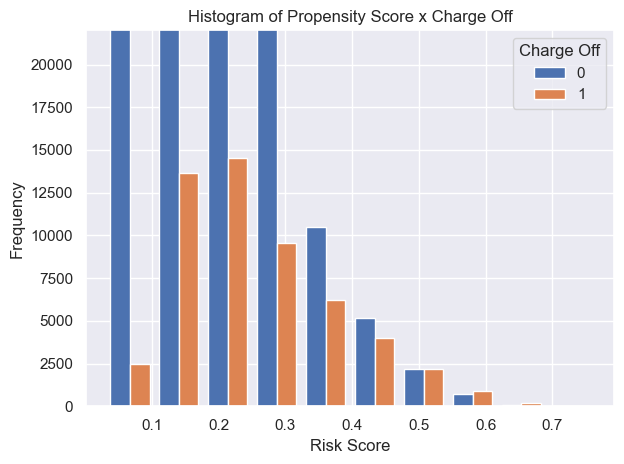

In [39]:

plot_hist_propension_score(Test)

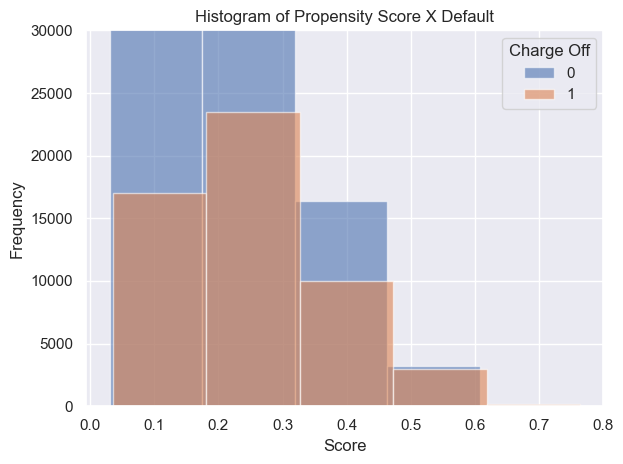

In [40]:

plot_hist_propension_score2(Test)